In [ ]:
import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
%matplotlib inline
import glob
from IPython.display import Image
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping

# Shared Input Layer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate

import seaborn as sns
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image


from google.colab import drive
drive.mount('/content/drive')
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [ ]:
## Bathroom.jpg
new_images=[]
for number in range(1, 536):
    for path in glob.glob("./drive/My Drive/Houses-dataset/Houses Dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
          new_images.append(path)

print(new_images)

['./drive/My Drive/Houses-dataset/Houses Dataset/1_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/2_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/3_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/4_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/5_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/6_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/7_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/8_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/9_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/10_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/11_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/12_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/13_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/14_bathroom.jpg', './drive/My Drive/Houses-dataset/Houses Dataset/15_bathroom.jpg', './drive/My Drive/

In [ ]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob("./drive/My Drive/Houses-dataset/Houses Dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path)


img['bedroom_img']=bedroom_images

frontal_images = []
for number in range(1, 536):
    for path in glob.glob("./drive/My Drive/Houses-dataset/Houses Dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path)

img['frontal_img']=frontal_images

kitchen_images = []
for number in range(1, 536):
    for path in glob.glob("./drive/My Drive/Houses-dataset/Houses Dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path)

img['kitchen_img']=kitchen_images


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    return df[result].values.astype(np.float32), df[target].values.astype(np.float32)


path = "./drive/"

filename = os.path.join(path,"My Drive/Houses-dataset/Houses Dataset/HousesInfo.txt")
cols=["Bedrooms","Bathrooms","area","zipcode","price"]
df = pd.read_csv(filename , sep=" ", header=None , names=cols)
df.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [ ]:
# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [ ]:
from sklearn import preprocessing
# normalizedValues = df.area
# df.area = normalizedValues / normalizedValues.std()

# normalize price
# Create x, where x the 'scores' column's values as floats
x = df[['price']].values

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
normalized = pd.DataFrame(x_scaled)
df.area = normalized

# normalize bathrooms
x = df[['Bathrooms']].values
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled)
df.Bathrooms = normalized

# normalize bedrooms
x = df[['Bedrooms']].values
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled)
df.Bedrooms = normalized

# zipcodes = df["zipcode"].value_counts().keys().tolist()
# counts = df["zipcode"].value_counts().tolist()
# for (zipcode, count) in zip(zipcodes, counts):
# 		if count < 10:
# 			idxs = df[df["zipcode"] == zipcode].index
# 			print(idxs)
      # df.drop(idxs, inplace=True)

# prices = df["price"].value_counts().keys().tolist()
prices = df['price']
i = 0
j = 0
for price in prices:
  if price <= 100000:
    j += 1
    img.drop(int(i), inplace=True)
    df.drop(int(i), inplace=True)
  elif price >= 900000:
    j += 1
    img.drop(int(i), inplace=True)
    df.drop(int(i), inplace=True)
  i += 1


In [ ]:
df = pd.get_dummies(df, columns=['zipcode'])

In [ ]:
df.head()

,Bedrooms,Bathrooms,area,price,zipcode_36372,zipcode_60002,zipcode_60016,zipcode_60046,zipcode_62025,zipcode_62034,zipcode_62088,zipcode_62214,zipcode_62234,zipcode_62249,zipcode_81418,zipcode_81521,zipcode_81524,zipcode_85255,zipcode_85262,zipcode_85266,zipcode_85331,zipcode_91752,zipcode_91901,zipcode_91915,zipcode_92021,zipcode_92253,zipcode_92276,zipcode_92543,zipcode_92677,zipcode_92692,zipcode_92802,zipcode_92880,zipcode_93105,zipcode_93111,zipcode_93314,zipcode_93446,zipcode_93510,zipcode_94501,zipcode_94531,zipcode_94565,zipcode_94568,zipcode_95220,zipcode_96019,zipcode_98021
0,0.333333,0.500000,0.145219,869500,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.333333,0.333333,0.144483,865200,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.222222,0.500000,0.148561,889000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0.222222,0.500000,0.133139,799000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0.444444,0.666667,0.085195,519200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
x,y = to_xy(df,"price")

In [ ]:
print(x.shape)
print(y.shape)

(405, 43)
(405,)


In [ ]:
print(x[0])
print(y[0])

[0.33333334 0.5        0.14521933 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
869500.0


In [ ]:
images_output=[]
for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))

            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))

            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))

            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))

            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)

            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[64:128, 0:64:] = inputImages[1]
            outputImage[:64, 64:128,] = inputImages[2]
            outputImage[64:128, 64:128] = inputImages[3]


            images_output.append(outputImage)

img_arr=np.asarray(images_output)
img_arr.shape

(405, 128, 128, 3)

In [ ]:
print(x.shape)
print(y.shape)
print(img_arr.shape)

(405, 43)
(405,)
(405, 128, 128, 3)


In [ ]:
print(img_arr[0])

[[[141 173 192]
  [110 143 170]
  [ 92 143 172]
  ...
  [ 16 106  85]
  [ 22  64  51]
  [  1  18  14]]

 [[145 181 191]
  [128 168 187]
  [ 87 131 161]
  ...
  [ 10  42  27]
  [ 10  62  42]
  [ 10  53  36]]

 [[100 138 157]
  [116 152 171]
  [102 147 175]
  ...
  [  5  42  27]
  [ 32  64  58]
  [ 10  46  33]]

 ...

 [[128 130 150]
  [125 130 156]
  [131 143 164]
  ...
  [129 171 196]
  [117 168 194]
  [131 174 194]]

 [[ 85  99 133]
  [121 152 183]
  [131 161 186]
  ...
  [146 188 213]
  [147 183 209]
  [144 184 206]]

 [[110 138 168]
  [123 157 181]
  [154 181 207]
  ...
  [131 183 214]
  [139 185 213]
  [146 190 213]]]


In [ ]:
# normalizing images in the range of 0 to 1
img_arr = img_arr / 255.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=50)
x_image_train, x_image_test = train_test_split(img_arr, test_size=0.30, random_state=50)
print(x_train.shape)
print(x_test.shape)
print(x_image_train.shape)
print(x_image_test.shape)
print(y_train.shape)
print(y_test.shape)

(283, 43)
(122, 43)
(283, 128, 128, 3)
(122, 128, 128, 3)
(283,)
(122,)


In [ ]:
print(x_train[0])
print(y_train[0])

[0.33333334 0.16666667 0.08704592 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.        ]
530000.0


In [ ]:
# loading transfer learning model
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# first input model
def basic_block(visible1):
  dense1 = Dense(150, activation='relu')(visible1)
  dense2 = Dense(140, activation='relu')(dense1)
  dense3 = Dense(130, activation='relu')(dense2)
  dense4 = Dense(150, activation='relu')(dense3)
  output1 = Dense(3, activation='relu')(dense4)
  return output1


visible1 = Input(shape=3)
output1 = basic_block(visible1)

zip_code = Input(shape=x.shape[1]-3)
output4 = basic_block(zip_code)
output5 = basic_block(concatenate([visible1, output4]))
output6 = basic_block(concatenate([visible1, output5]))

# second input model
image1 = Input(shape=(128,128,3))

# add new classifier layers
base_output1 = base_model(image1)
global_average_layer1 = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average1 = global_average_layer1(base_output1)
flat11 = Flatten()(feature_batch_average1)
output71 = Dense(40, activation='relu')(flat11)

# merge input models
merge = concatenate([output1, output6, output71,])


# interpretation model
hidden1 = Dense(50, activation='relu')(merge)
hidden2 = Dense(20, activation='relu')(hidden1)
hidden3 = Dense(5, activation='relu')(hidden2)
output = Dense(1, activation='linear')(hidden3)


model = Model(inputs=[visible1, zip_code, image1], outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model, show_shapes=True)
print('done')

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
dense_190 (Dense)               (None, 150)          6150        input_26[0][0]                   
__________________________________________________________________________________________________
dense_191 (Dense)               (None, 140)          21140       dense_190[0][0]                  
__________________________________________________________________________________________________
dense_192 (Dense)               (None, 130)          18330       dense_191[0][0]                  
____________________________________________________________________________________________

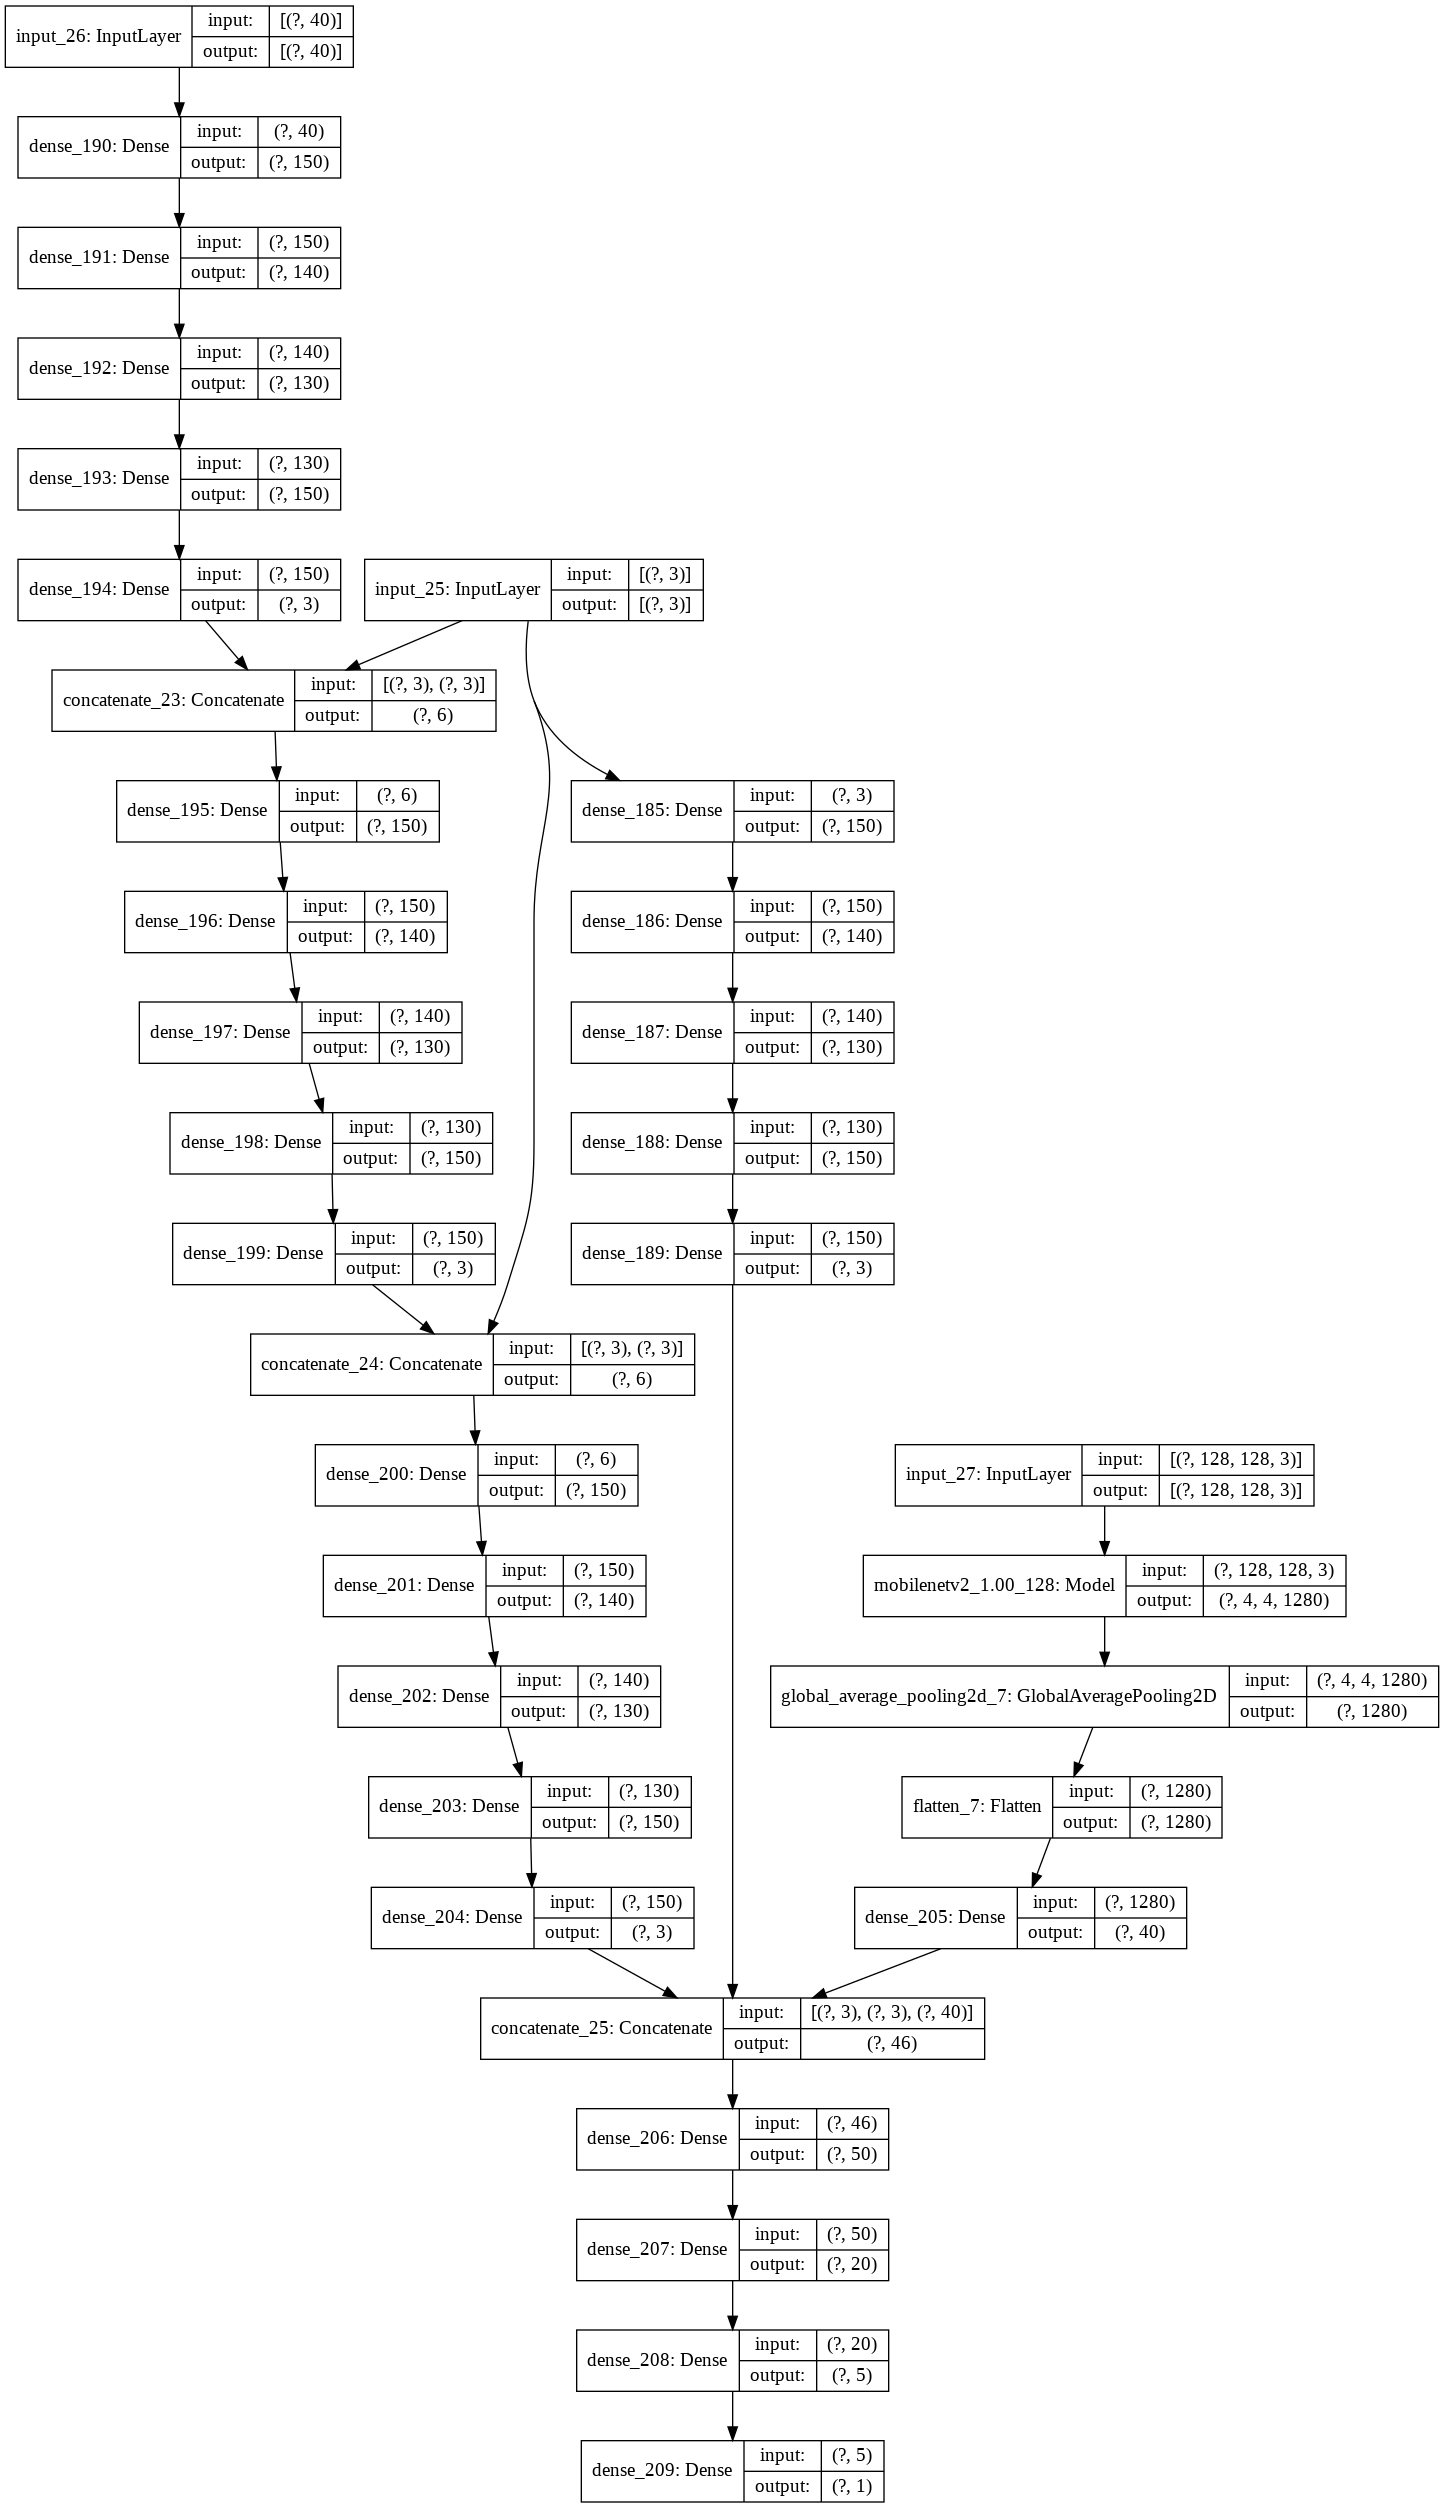

In [ ]:
# plot graph
plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=0, save_best_only=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, verbose=2, mode='auto')

model.fit(
	[x_train[:, 0:3], x_train[:, 3:], x_image_train], y_train,
	validation_data=([x_test[:, 0:3], x_test[:, 3:], x_image_test], y_test),
	epochs=30, batch_size=32, callbacks = [checkpointer, monitor])


Train on 283 samples, validate on 122 samples
Epoch 1/30
283/283 [==============================] - 4s 14ms/sample - loss: 100.0000 - val_loss: 99.9999
Epoch 2/30
283/283 [==============================] - 1s 3ms/sample - loss: 99.9999 - val_loss: 99.9997
Epoch 3/30
283/283 [==============================] - 1s 3ms/sample - loss: 99.9996 - val_loss: 99.9991
Epoch 4/30
283/283 [==============================] - 1s 3ms/sample - loss: 99.9988 - val_loss: 99.9975
Epoch 5/30
283/283 [==============================] - 1s 3ms/sample - loss: 99.9970 - val_loss: 99.9943
Epoch 6/30
283/283 [==============================] - 1s 3ms/sample - loss: 99.9934 - val_loss: 99.9878
Epoch 7/30
283/283 [==============================] - 1s 3ms/sample - loss: 99.9863 - val_loss: 99.9753
Epoch 8/30
283/283 [==============================] - 1s 3ms/sample - loss: 99.9727 - val_loss: 99.9535
Epoch 9/30
283/283 [==============================] - 1s 3ms/sample - loss: 99.9499 - val_loss: 99.9155
Epoch 10/30
283/

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("best_weights.hdf5")
ypred = model.predict([x_test[:, 0:3], x_test[:, 3:], x_image_test])
score = np.sqrt(metrics.mean_squared_error(ypred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 151737.859375


In [ ]:
print(metrics.r2_score(ypred,y_test))
# Plot the chart
chart_regression(ypred.flatten(),y_test, sort=True)

0.09553445169753949


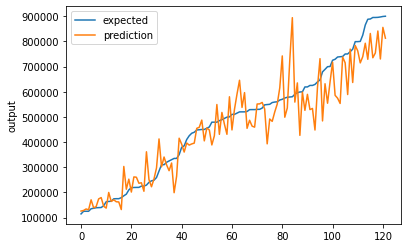

In [ ]:
# Plot the chart
chart_regression(ypred.flatten(),y_test, sort=True)